In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import pickle
import cartopy.crs as ccrs
import geopandas as gpd
from palettable.colorbrewer.sequential import YlGnBu_9
import gdal

import pyproj
from pyproj import Geod
from pyproj import Proj, transform
from fiona.crs import from_epsg
from osgeo import osr

# Open common datasets

In [2]:
# ATL15
src_path = "ATL15_AA_0311_01km_001_01.nc"
ds = xr.open_dataset(src_path, group='delta_h')
indf = 9
ind0 = 5
dh = ds['delta_h'][indf,:,:] - ds['delta_h'][ind0,:,:]
print(ds['time'][ind0].values)
print(ds['time'][indf].values)

# SMB Perturbation
M2_RF = xr.open_dataset("RF_Snow_Red_prelim.nc")['IS2_opt']
M2_RF = M2_RF / M2_RF
M2_RF = M2_RF.fillna(1)

# Grounded mask
grounded_mask = np.load("grounded-mask/grounded_mask.npy")
grounded_mask = xr.DataArray(data=np.flipud(grounded_mask), dims=["y", "x"], coords=[ds['y'],ds['x']])

# Trim to comain domain
dh = dh * grounded_mask * M2_RF

2020-01-01T12:00:00.000000000
2020-12-31T18:00:00.000000000


# Load in ensemble dFAC solutions

In [3]:
dFAC = np.load("2020_Inference_Y_ensemble.npy")
dFAC_deterministic = np.load("2020_Inference_Y.npy")
print(dFAC.shape)
print(dFAC_deterministic.shape)

(22977621, 100)
(22977621,)


In [4]:
# Calculate mean and standard deviation
dFAC_mean = np.mean(dFAC, axis=1)
dFAC_std = np.std(dFAC, axis=1)

# Plot map pf standard deviation dFAC

In [5]:
dFAC_std = xr.DataArray(data=np.reshape(dFAC_std, dh.shape), dims=["y", "x"], coords=[dh['y'], dh['x']])
dFAC_std = dFAC_std * grounded_mask * M2_RF

dFAC_deterministic = xr.DataArray(data=np.reshape(dFAC_deterministic, dh.shape), dims=["y", "x"], coords=[dh['y'], dh['x']])
dFAC_deterministic = dFAC_deterministic * grounded_mask * M2_RF

# This map doesn't actually seem very useful! 
# ensemble_std_scale = np.abs(dFAC_std / dFAC_deterministic)
# plt.figure(figsize=(8.25, 5))
# ensemble_std_scale.plot(vmin=-1, vmax=1) # vmax=10 is too high

In [6]:
df = gpd.read_file("/pl/active/nasa_smb/Data/ADD_Coastline_low_res_polygon.shp")
df = df.to_crs(epsg='3031')
n_poly = len(df['geometry'])

/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


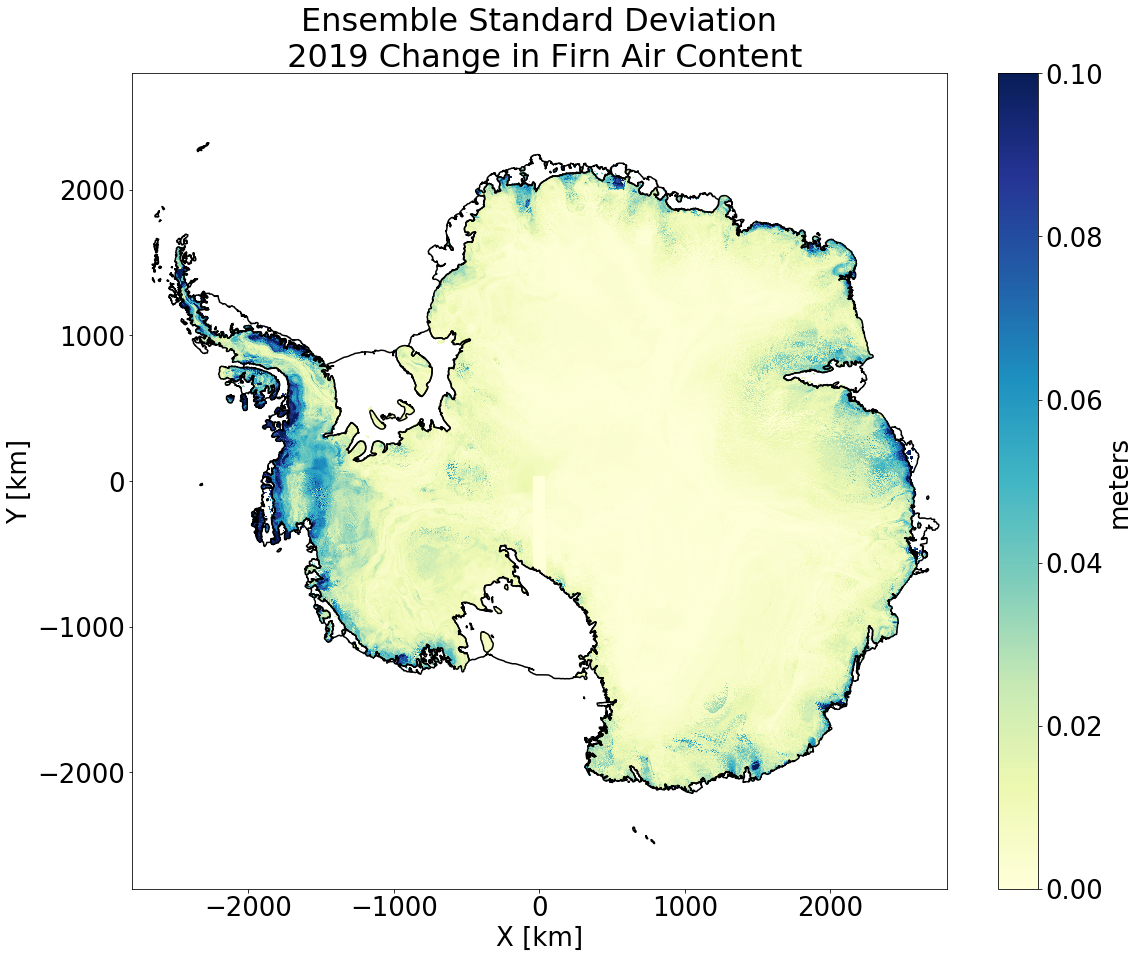

In [7]:
# dFAC
# lim = np.max(np.abs(dFAC_std))
lim = 0.1
axis_lim = 2800

plt.figure(figsize=(18.25, 15))

for j in range(0, n_poly):
    x_poly, y_poly = df['geometry'][j].exterior.coords.xy
    x_poly = np.array(x_poly)
    y_poly = np.array(y_poly)
    x_poly = np.append(x_poly/1000, x_poly[0]/1000)
    y_poly = np.append(y_poly/1000, y_poly[0]/1000)
    plt.plot(x_poly, y_poly, 'k-')

plt.pcolormesh(dFAC_std['x']/1000, dFAC_std['y']/1000, \
           dFAC_std, cmap=YlGnBu_9.mpl_colormap, \
          vmin=0, vmax=lim, rasterized=True)
cb = plt.colorbar()
cb.set_label("meters", fontsize=26)
cb.ax.tick_params(labelsize=26) 
plt.xlabel("X [km]", fontsize=26)
plt.ylabel("Y [km]", fontsize=26)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.title("Ensemble Standard Deviation\n 2019 Change in Firn Air Content", fontsize=32)
plt.xlim([-axis_lim, axis_lim])
plt.ylim([-axis_lim, axis_lim])
plt.savefig("figures/dFAC_std_map_AIS.pdf", dpi=100)

# Plot ensemble histogram of ice sheet average dFAC

In [8]:
tmp = dFAC.flatten()
tmp = tmp.reshape((4401, 5221, 100))
tmp.shape
dFAC_ensemble = xr.DataArray(data=tmp, dims=["y", "x", "ensemble"], coords=[dh['y'], dh['x'], np.arange(1, 101)])
dFAC_ensemble = dFAC_ensemble * grounded_mask * M2_RF
ice_sheet_average_dFAC = dFAC_ensemble.mean(dim='x').mean(dim='y').values

/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


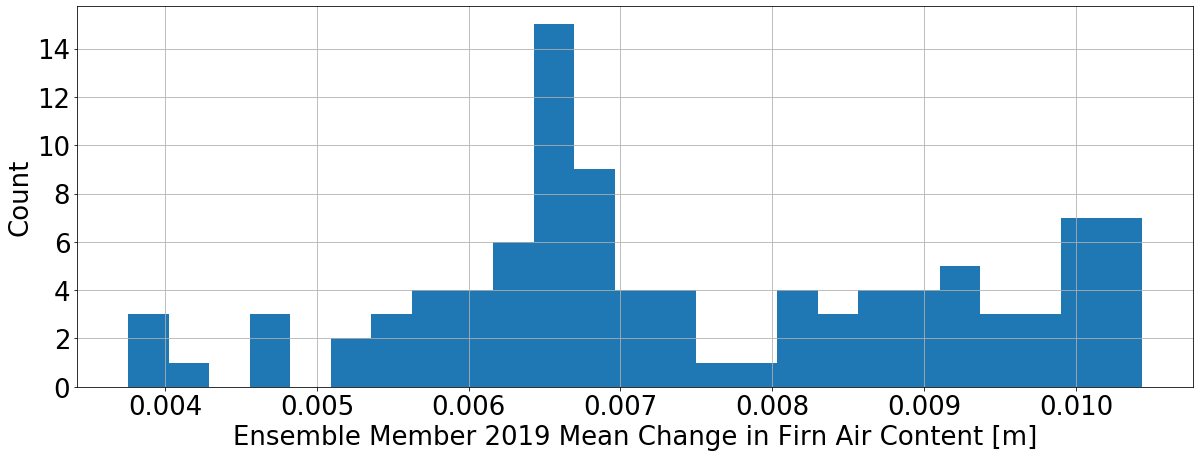

In [9]:
plt.figure(figsize=(20, 7))
plt.hist(ice_sheet_average_dFAC, bins=25)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.xlabel("Ensemble Member 2019 Mean Change in Firn Air Content [m]", fontsize=26)
plt.ylabel("Count", fontsize=26)
plt.grid()
plt.savefig("figures/dFAC_AIS_ensemble.pdf", dpi=100)

# Create Figure 5
Box and whisker plots showing min, -std, mean, deterministic, +std, max basin average dFAC values

In [10]:
# %%bash
# ml intel/17.4; ml proj/6.0.0; ml gdal/3.4.2; ml netcdf;

# # This works for getting individual basins. But sets 1 outside, which is also a basin number!
# gdal_rasterize -b 1 -a ID GSFC_DrainageSystems.shp out.tif 

# # Get the inside of the polygons
# gdal_translate -b 1 NETCDF:ATL15_AA_0311_01km_001_01.nc:/delta_h/delta_h out2.tif
# gdal_rasterize -i -burn -9999 GSFC_DrainageSystems.shp out2.tif

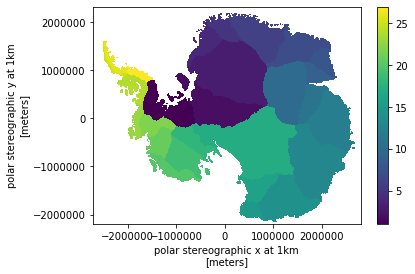

In [11]:
tif2 = gdal.Open("/projects/erke2265/tmp/out2.tif")
band2 = tif2.GetRasterBand(1)
basins2 = band2.ReadAsArray()
basins2[basins2<-100] = np.nan
basins2[basins2>=-10] = 1
basins2 = xr.DataArray(data=np.flipud(basins2), dims=["y", "x"], coords=[ds['y'],ds['x']])

tif = gdal.Open("/projects/erke2265/tmp/out.tif")
band = tif.GetRasterBand(1)
basins = band.ReadAsArray()
basins = xr.DataArray(data=np.flipud(basins), dims=["y", "x"], coords=[ds['y'],ds['x']])
basins = basins * grounded_mask * basins2
basins.plot()

In [12]:
n_basins = 28 # Full ice sheet, 27 basins. 28 total
n_values = 100
data = np.zeros([n_values, n_basins]); data[:] = np.nan
deterministic = np.zeros([1, n_basins]); deterministic[:] = np.nan

for j in range(0, n_basins):
# for j in range(0, 2):
    
    # Entire ice sheet
    if j == 0: 
        print("AIS")

        # Ensemble
        dh_corr = dh - dFAC_ensemble
        dM = (917 * dh_corr * ds['cell_area'])
        dM_val = dM.sum(dim='x').sum(dim='y').values 
        data[:, j] = dM_val / 1e12 # Units = Gt
        
        # Deterministic
        dh_corr_det = dh - dFAC_deterministic
        dM_det = (917 * dh_corr_det * ds['cell_area'])
        dM_det = dM_det.sum(dim='x').sum(dim='y').values 
        deterministic[0, j] = dM_det / 1e12 # Units = Gt
        
        
    # Individual basin
    else:
        print("Basin " + str(j))

        # Ensemble
        basin_mask = basins.where(basins == j) / basins.where(basins == j)
        dM_basin = dM * basin_mask
        dM_basin_val = dM_basin.sum(dim='x').sum(dim='y').values 
        data[:, j] = dM_basin_val / 1e12 # Units = Gt
        
        # Deterministic
        dh_corr_det = (dh - dFAC_deterministic) * basin_mask
        dM_det = (917 * dh_corr_det * ds['cell_area'])
        dM_det = dM_det.sum(dim='x').sum(dim='y').values 
        deterministic[0, j] = dM_det / 1e12 # Units = Gt
        


AIS
Basin 1
Basin 2
Basin 3
Basin 4
Basin 5
Basin 6
Basin 7
Basin 8
Basin 9
Basin 10
Basin 11
Basin 12
Basin 13
Basin 14
Basin 15
Basin 16
Basin 17
Basin 18
Basin 19
Basin 20
Basin 21
Basin 22
Basin 23
Basin 24
Basin 25
Basin 26
Basin 27


# Make violin plot

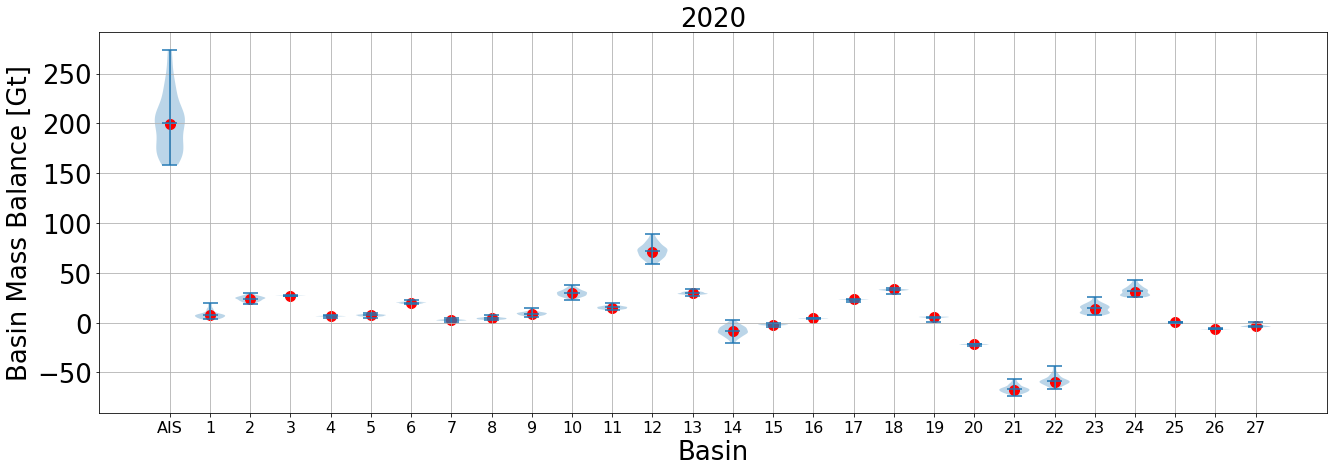

In [13]:
plt.figure(figsize=(22, 7))
labels = ['AIS', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27']
# lim = 20
plt.violinplot(data, widths=0.75, showmeans=True)
inds = np.arange(1, len(labels) + 1)
plt.scatter(inds, deterministic, c='r', s=100)
plt.grid()
plt.xticks(np.arange(1, len(labels) + 1), labels=labels)
plt.xticks(fontsize=16)
plt.yticks(fontsize=26)
# plt.ylim([-lim, lim])
plt.xlabel("Basin", fontsize=26)
plt.ylabel("Basin Mass Balance [Gt]", fontsize=26)
plt.title("2020", fontsize=26)
plt.savefig("figures/ensemble_violin.pdf", dpi=100)